# Visualize Query → Top-K Matches

This notebook reads `query_to_neighbors.csv` (generated by `map_queries_to_closest_csv.py`) and displays each query image alongside its top-K gallery matches. It attempts to map annotation IDs to image paths using the same loaders used elsewhere in the repo.

Instructions: update the `CSV_PATH` and `PREPROCESS_DIR` variables below if your files are in different locations.

In [ ]:
import os
import sys
from pathlib import Path
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import cv2
from IPython.display import display

# ensure local modules are importable
sys.path.append('..')
sys.path.append('../..')
sys.path.append('../../wbia-plugin-miew-id')
sys.path.append('../../wildlife-embeddings/')
from loaders import whale_inquire_data, wildlife_datasets_data, CLUSTER_WD_PATH
from wildlife_datasets import datasets

CSV_PATH = 'query_to_neighbors.csv'
PREPROCESS_DIR = 'inat_happywhale_embeddings_combined'
TOP_K = 3
OUT_DIR = 'viz_matches'
os.makedirs(OUT_DIR, exist_ok=True)

In [ ]:
# load metadata to map annot -> image paths
inquire_csv = 'whale_results_with_url_filtered.csv'
dataset_cls = datasets.humpback_whale_id.HumpbackWhaleID
inquire_df = whale_inquire_data(inquire_csv)
wd_df = wildlife_datasets_data(dataset_cls, cluster=True)
# normalize wd image paths like other scripts do
try:
    wd_df["image"] = os.path.join(CLUSTER_WD_PATH, dataset_cls.__name__) + "/" + wd_df["image"]
except Exception:
    pass

# build annot -> image map (inquiry + gallery)
annot_to_image = {}
for _, r in inquire_df.iterrows():
    annot_to_image[r['annot']] = r.get('image', None)
for _, r in wd_df.iterrows():
    annot_to_image[r['annot']] = r.get('image', None)

len(annot_to_image)

In [ ]:
# helper to create a horizontal montage of images given a list of PIL images
from PIL import Image

def make_row(images, thumb_h=256, pad=5):
    thumbs = []
    for im in images:
        if im is None:
            continue
        w, h = im.size
        new_w = int(w * (thumb_h / float(h)))
        thumbs.append(im.resize((new_w, thumb_h)))
    if len(thumbs) == 0:
        return None
    total_w = sum(im.size[0] for im in thumbs) + pad * (len(thumbs)-1)
    out = Image.new('RGB', (total_w, thumb_h), (255,255,255))
    x = 0
    for im in thumbs:
        out.paste(im, (x, 0))
        x += im.size[0] + pad
    return out


def load_img_from_annot(annot, fallback_show_missing=True, thumb_h=256):
    path = annot_to_image.get(annot)
    if path is None or not os.path.exists(path):
        if fallback_show_missing:
            return Image.new('RGB', (thumb_h, thumb_h), color=(200, 200, 200))
        return None
    try:
        return Image.open(path).convert('RGB')
    except Exception:
        return Image.new('RGB', (thumb_h, thumb_h), color=(255, 0, 0))


# iterate over unique queries and build montages
csv_df = pd.read_csv(CSV_PATH)
groups = csv_df.groupby('query_annot')
for q_annot, g in groups:
    # sort by rank
    g = g.sort_values('rank')
    imgs = []
    imgs.append(load_img_from_annot(q_annot))
    for _, row in g.iterrows():
        imgs.append(load_img_from_annot(row['neighbor_annot']))
    montage = make_row(imgs, thumb_h=256)
    if montage is None:
        continue
    out_path = os.path.join(OUT_DIR, f'{q_annot}.jpg')
    montage.save(out_path)
    display(montage)


# Mapping the trajectory of the same individual (3db0abc03) mapped to the same happywhale data points) across inat observations

In [ ]:
# "https://www.inaturalist.org/photos/394125881" --> mlat=49.19&mlon=-123.726
# "https://www.inaturalist.org/photos/402958308", --> mlat=49.205&mlon=-123.6966666667
# "https://www.inaturalist.org/photos/408635531", --> mlat=49.0378333333&mlon=-123.5128333333

Object `Canada` not found.


/tmp/ipykernel_2021606/2414745783.py:23: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax.legend()


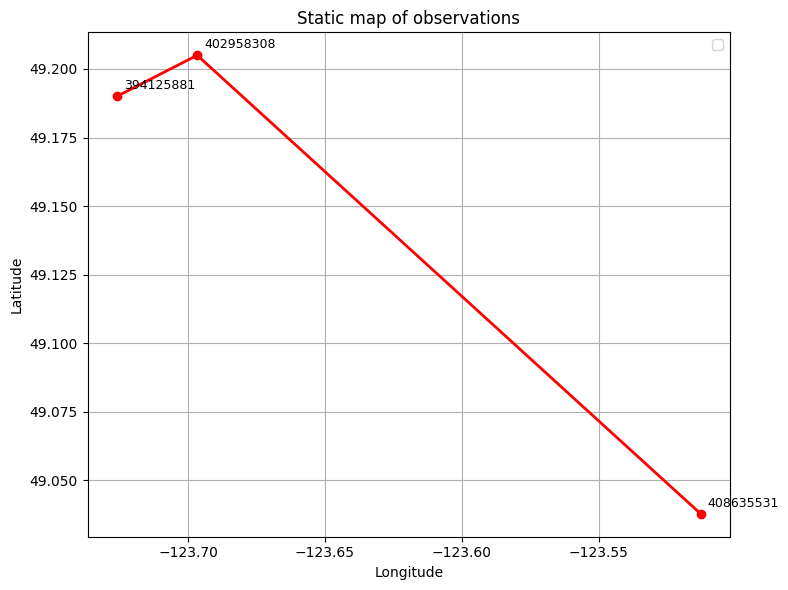

In [ ]:
import matplotlib.pyplot as plt

# Create a simple static map (matplotlib) using existing `coords` and `urls`.
# Note: coords is a list of (lat, lon); matplotlib expects x=lon, y=lat.
lats, lons = zip(*coords)

fig, ax = plt.subplots(figsize=(8, 6))
ax.plot(lons, lats, '-o', color='red', linewidth=2, markersize=6)

# Annotate points with photo ids (taken from the URL)
for u, lat, lon in zip(urls, lats, lons):
    pid = u.rstrip('/').rsplit('/', 1)[-1]
    ax.annotate(pid, (lon, lat), textcoords="offset points", xytext=(5, 5), ha="left", fontsize=9)

# Mark the computed center
# ax.plot(center[1], center[0], marker='x', color='blue', markersize=10, label='center')


ax.set_xlabel("Longitude")
ax.set_ylabel("Latitude")
ax.set_title("Static map of observations")
ax.grid(True)
ax.legend()
plt.tight_layout()
plt.show()

In [ ]:
import folium
from IPython.display import display

# define coords, urls, and center based on prior comments/URLs
coords = [
    (49.19, -123.726),
    (49.205, -123.6966666667),
    (49.0378333333, -123.5128333333),
]
urls = [
    "https://www.inaturalist.org/photos/394125881",
    "https://www.inaturalist.org/photos/402958308",
    "https://www.inaturalist.org/photos/408635531",
]

# compute center (latitude, longitude)
lats, lons = zip(*coords)
center = (sum(lats) / len(lats), sum(lons) / len(lons))


# Use existing variables: coords (list of (lat, lon)), urls, center
center_loc = (center[0], center[1])

# Create an OSM (OpenStreetMap) folium map focused on the computed center
m = folium.Map(location=[center_loc[0], center_loc[1]], zoom_start=12, tiles="OpenStreetMap")

# Draw polyline connecting observations
folium.PolyLine(locations=[(lat, lon) for lat, lon in coords], color="#4285f4", weight=3, opacity=1.0).add_to(m)

# Add markers with popups linking to the photo URL (photo id shown)
for u, (lat, lon) in zip(urls, coords):
    pid = u.rstrip("/").rsplit("/", 1)[-1]
    popup_html = f'<a href="{u}" target="_blank" rel="noopener">{pid}</a>'
    folium.CircleMarker(location=(lat, lon), radius=6, color="#4285f4", fill=True, fill_color="#4285f4",
                        popup=folium.Popup(popup_html, max_width=200)).add_to(m)

# Display the map inline in the notebook
display(m)